<a href="https://colab.research.google.com/github/DariMe20/SocialNetworkAnalysis/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment — Random graphs

In [1]:
from zlib import adler32
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import requests
import networkx as nx
import scipy.stats as st
import numpy as np

### Task 1. Erdos-Renyi model (0 points)

Implement Erdos Renyi model (random graph) — each pair of $n$ nodes are connected with some fixed probability $p$.

In [2]:
def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G

Write a function `random_edges` with parameters: `nodes` — np.array of nodes, for example [1, 2, 3, 4, ...] and `p` — probability of connection. The function returns np.array with tuples of the form [(1, 2), (2, 4), ...], where 1-2, 2-4 are edges that should be added in the graph.

*Hint: To speed up the generation, look at ALG.1 in the article [Efficient generation of large random networks](http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf).*

In [3]:
def random_edges(nodes, p):
    nodes = np.asarray(nodes)
    n = len(nodes)
    if n < 2 or p <= 0:
        return np.array([], dtype=object)
    if p >= 1:
        # all unordered pairs
        i, j = np.triu_indices(n, k=1)
        return np.array(list(zip(nodes[i], nodes[j])), dtype=object)

    edges = []
    lp = np.log1p(-p)  # log(1 - p) < 0

    for u in range(n - 1):
        v = u
        while True:
            r = np.random.random()
            skip = int(np.floor(np.log1p(-r) / lp))  # geometric skip
            v += skip + 1
            if v >= n:
                break
            edges.append((nodes[u], nodes[v]))

    return np.array(edges, dtype=object)

In [4]:
'''Check the Erdos-Renyi random graph generation'''
assert len(erdos_renyi_graph(100, 0.1).edges) > 0
n = 100
p = 0.4
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 1000
p = 0.01
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 300
p = 0.9
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma

Let us draw a couple of generated graphs

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-272207482.py:2: SyntaxWarning: invalid escape sequence '\c'
  cases = [('Subcritical regime: $p \cdot n < 1$', n, 0.5/n),
/tmp/ipython-input-272207482.py:3: SyntaxWarning: invalid escape sequence '\c'
  ('Critical point: $p \cdot n = 1$', n, 1/n),
/tmp/ipython-input-272207482.py:4: SyntaxWarning: invalid escape sequence '\c'
  ('Supercritacal regime: $p \cdot n > 1$', n, 2/n),
/tmp/ipython-input-272207482.py:5: SyntaxWarning: invalid escape sequence '\c'
  ('Connected regime: $p \cdot n > \log(N)$', n, 6.5/n)]


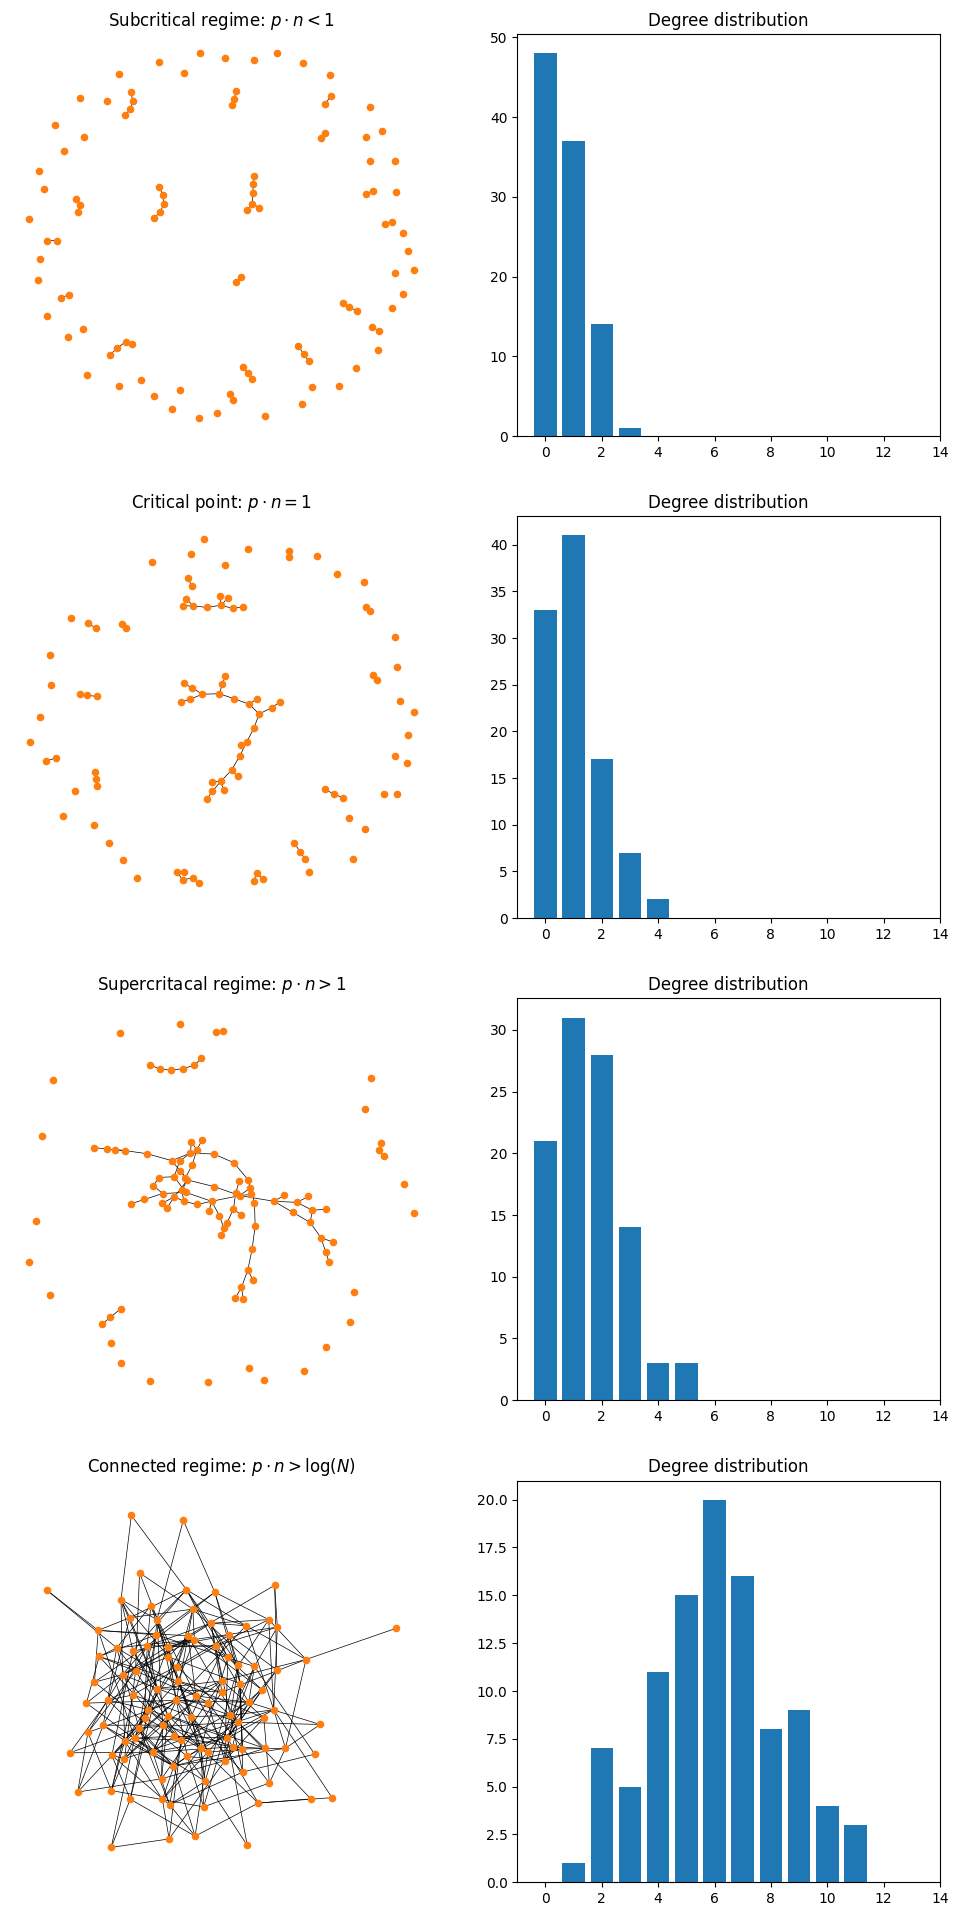

In [5]:
n = 100
cases = [('Subcritical regime: $p \cdot n < 1$', n, 0.5/n),
         ('Critical point: $p \cdot n = 1$', n, 1/n),
         ('Supercritacal regime: $p \cdot n > 1$', n, 2/n),
         ('Connected regime: $p \cdot n > \log(N)$', n, 6.5/n)]
plt.figure(figsize=(12, 6 * 4))
i = 1
for regime, n, p in cases:
    plt.subplot(4, 2, i)
    G = erdos_renyi_graph(n, p)
    nx.draw(
        G,
        with_labels=False,
        node_size=20,
        width=0.5,
        node_color='tab:orange')
    plt.title(regime)
    i += 1
    plt.subplot(4, 2, i)
    degree_seq = [degree for (node, degree) in G.degree]
    bins, freq = np.unique(degree_seq, return_counts=True)
    plt.bar(bins, freq)
    plt.xlim((-1, 14))
    plt.title('Degree distribution')
    i += 1

### Task 2. Fitting parameters of degree distribution (0 points)

In the Erdos-Renyi model, we can estimate a degree distribution using the binomial distribution. The binomial distribution $B(n, p)$ converges to the Poisson $\text{Pois}(\lambda)$ when the number of samples $n$ tends to infinity with the fixed product $np = \lambda$.

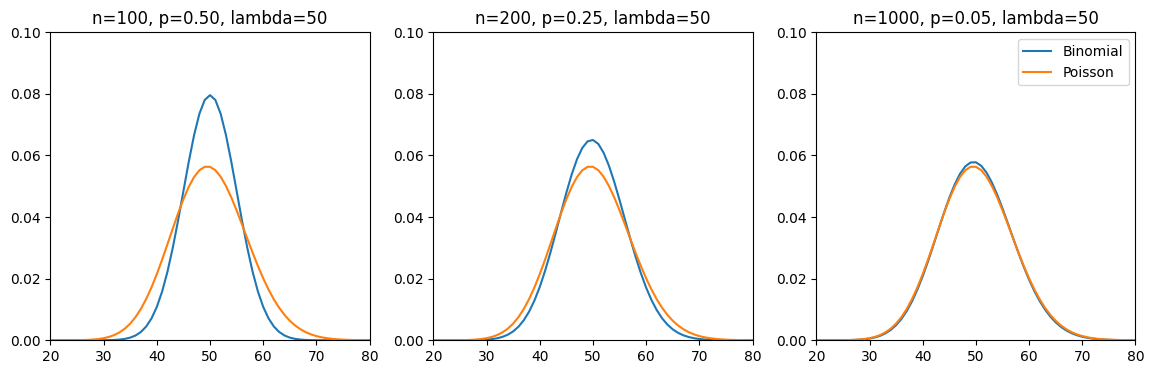

In [6]:
plt.figure(figsize=[14, 4])
for i, [n, mean] in enumerate([[100, 50], [200, 50], [1000, 50]]):
    plt.subplot(1, 3, i+1)
    plt.plot(st.binom(n, mean / n).pmf(np.arange(100)),
             label="Binomial")
    plt.plot(st.poisson(mean).pmf(np.arange(100)),
             label="Poisson")
    plt.xlim(20, 80)
    plt.ylim(0, 0.1)
    plt.title('n={}, p={:.2f}, lambda={}'.format(n, mean / n, mean))
plt.legend(loc='upper right');

In this task we will estimate properties of Binomial and Poisson distributions and compare in what cases it is better to use Binomial.

Write a function `estimate_binomial` that takes a random graph and returns binomial parameters `n` and `p`.

In [8]:
def estimate_binomial(G):
    n = G.number_of_nodes()
    if n <= 1:
        return n, 0.0
    m = G.number_of_edges()
    p = (2.0 * m) / (n * (n - 1))
    p = max(0.0, min(1.0, p))
    return n, p


In [9]:
G = erdos_renyi_graph(100, 0.5)
n, p = estimate_binomial(G)
assert abs(p - 0.5) <= 0.05
assert n == 100

Write a function `estimate_poisson` that takes a random graph and returns the Poisson parameter $\lambda$ (here denoted as `m`).

In [10]:
def estimate_poisson(G):
    degrees = np.array([d for _, d in G.degree()])
    lam = degrees.mean()  # Poisson λ = average degree
    return float(lam)

In [11]:
G = erdos_renyi_graph(1000, 0.05)
m = estimate_poisson(G)
assert abs(m - 50) <= 1

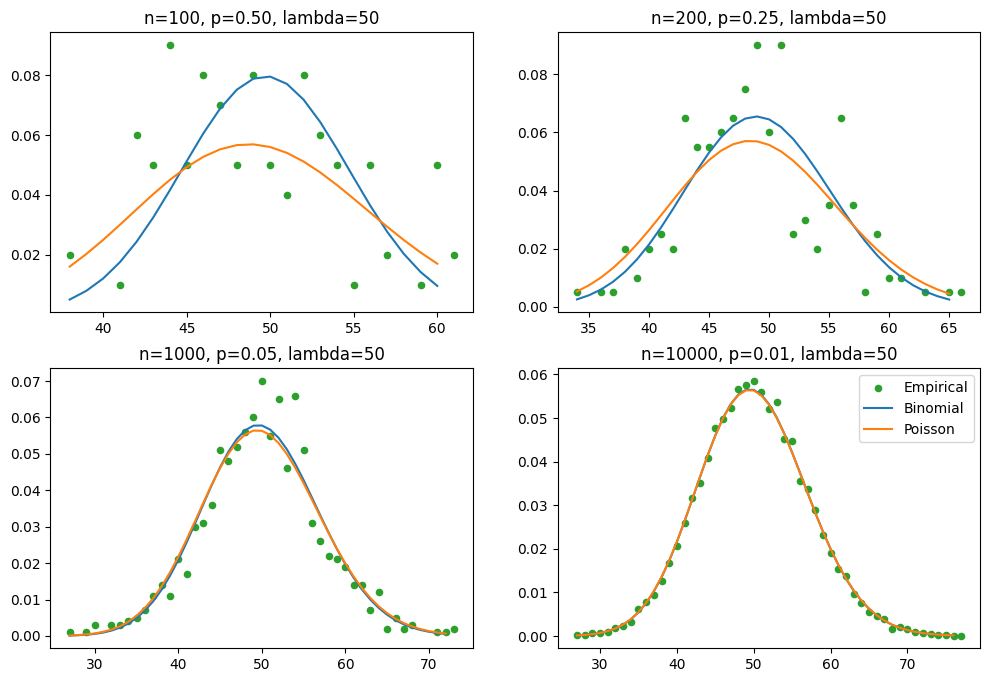

In [12]:
plt.figure(figsize=[12, 8])
for i, [n, p] in enumerate([[100, 0.5], [200, 0.25], [1000, 0.05], [10000, 0.005]]):
    plt.subplot(2, 2, i+1)
    G = erdos_renyi_graph(n, p)
    degree_density = np.array(nx.degree_histogram(G)) / n
    idx = np.argwhere(degree_density > 0)
    plt.scatter(idx, degree_density[idx], label="Empirical", c='tab:green', s=20)
    degrees = dict(G.degree).values()
    k_space = np.arange(min(degrees), max(degrees))
    plt.plot(k_space, st.binom(*estimate_binomial(G)).pmf(k_space), label="Binomial")
    plt.plot(k_space, st.poisson(estimate_poisson(G)).pmf(k_space), label="Poisson")
    plt.title(f'n={n}, p={p:.2f}, lambda={n*p:.0f}')
plt.legend()
plt.show()

### Task 3. Degree distribution of random vs real networks (0 points)

In [13]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/wiki_vote.txt'
open('wiki_vote.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/facebook_combined.txt'
open('facebook_combined.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/collaboration_network_of_arxiv_general_relativity_category.txt'
open('collaboration_network_of_arxiv_general_relativity_category.txt', 'wb').write(requests.get(url).content);


Let us compare degree distributions of real and random networks and decide whether they are close or not.

Write a function `random_from_real` that takes a graph and returns a random network that has the same average node degree and the same number of nodes as a given network.

In [14]:
def random_from_real(graph):
    n = graph.number_of_nodes()
    if n <= 1:
        return nx.empty_graph(n)
    mean_degree = np.mean([d for _, d in graph.degree()])
    p = mean_degree / (n - 1)
    p = max(0.0, min(1.0, p))  # clamp to [0,1]
    return nx.erdos_renyi_graph(n, p)


In [15]:
for file in ['wiki_vote.txt',
             'collaboration_network_of_arxiv_general_relativity_category.txt',
             'facebook_combined.txt']:
    real_net = nx.read_edgelist(file)
    random_net = random_from_real(real_net)
    av_degree_random = np.mean(list(dict(random_net.degree).values()))
    av_degree_real = np.mean(list(dict(real_net.degree).values()))
    assert len(random_net) == len(real_net)
    assert np.abs(av_degree_random - av_degree_real) < 1

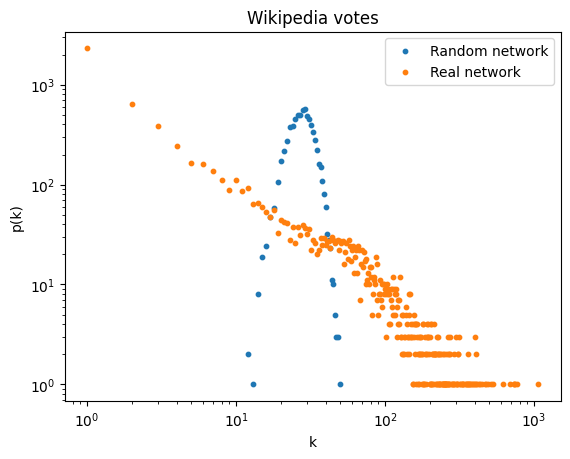

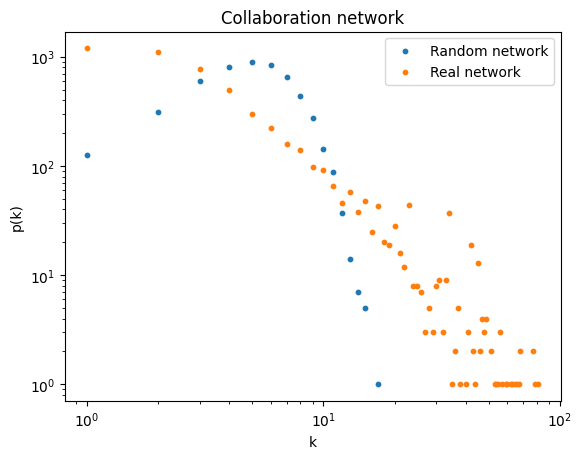

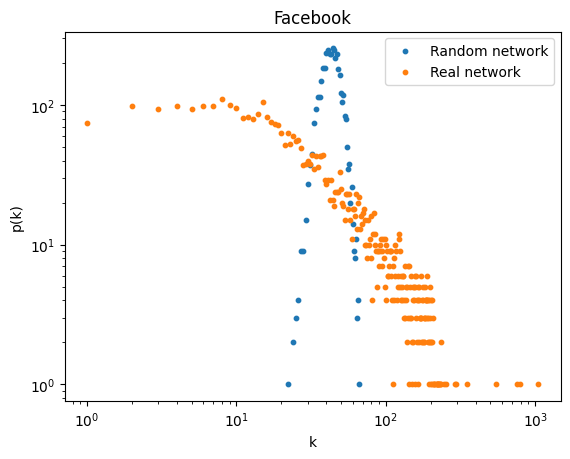

In [16]:
cases = [['Wikipedia votes', 'wiki_vote.txt'],
         ['Collaboration network', 'collaboration_network_of_arxiv_general_relativity_category.txt'],
         ['Facebook', 'facebook_combined.txt']]
for title, file in cases:
    real_net = nx.read_edgelist(file)
    random_net = random_from_real(real_net)
    degree_hist = np.array(nx.degree_histogram(random_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Random network')
    degree_hist = np.array(nx.degree_histogram(real_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Real network')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

### Task 4. Size of components in random graphs (3 points)

Let us see how the size of small components (small — not giant) depends on the probability near the critical point: $p =1/n$.

Write a function `small_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of average sizes of small components.

*Hint: to find nodes in components, use `nx.connected_components(graph)`*

In [17]:
def small_component_size(n, probabilities):
    avg_sizes = []
    for p in probabilities:
        G = nx.erdos_renyi_graph(n, p)
        comps = [len(c) for c in nx.connected_components(G)]
        if not comps:
            avg_sizes.append(0.0)
            continue
        giant = max(comps)
        small = [s for s in comps if s < giant]
        avg_sizes.append(np.mean(small) if small else 0.0)
    return np.array(avg_sizes, dtype=float)

In [18]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = small_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < av_sizes[np.argmin(np.abs(p_space*n - 1))]
assert av_sizes[49] < av_sizes[np.argmin(np.abs(p_space*n - 1))]

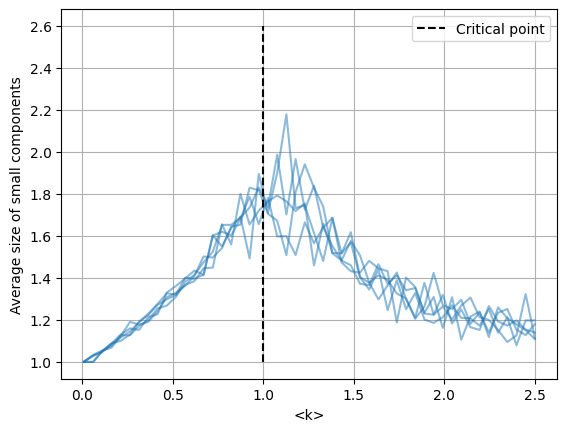

In [19]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [1, 2.6], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Average size of small components')
plt.legend()
plt.grid()
plt.show()

Also let us see how the size of a giant component depends on the probability near the critical point.

Write a function `giant_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of sizes of a giant component.

*Hint: to find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*

In [20]:
def giant_component_size(n, probabilities):
    sizes = []
    for p in probabilities:
        G = nx.erdos_renyi_graph(n, p)
        if G.number_of_nodes() == 0:
            sizes.append(0.0)
            continue
        if nx.number_connected_components(G) == 0:
            sizes.append(0.0)
            continue
        # largest component
        giant = max(nx.connected_components(G), key=len)
        sizes.append(len(giant))
    return np.array(sizes, dtype=float)

In [21]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = giant_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < 20
assert 20 < av_sizes[np.argmin(np.abs(p_space*n - 1))] < 150
assert 700 < av_sizes[np.argmin(np.abs(p_space*n - 2))] < 900

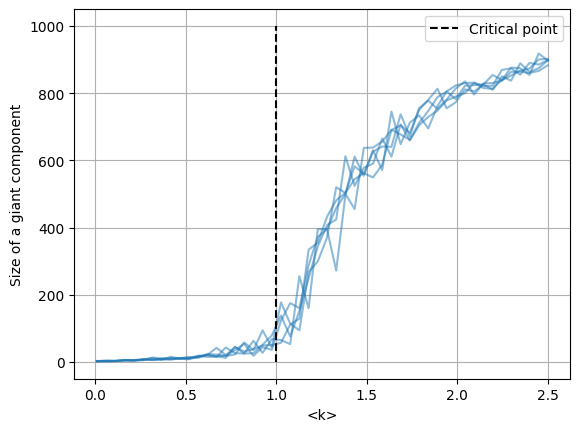

In [22]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [0, 1000], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Size of a giant component')
plt.legend()
plt.grid()
plt.show()

### Task 5. Average path length in random graphs (2 points)

In this task, we consider whether a random network is capable to model the small world phenomenon, also known as six degrees of separation — the distance between two randomly chosen nodes in a network is short. In other words, the average path length between two randomly chosen nodes increases in a growing network, but not so fast as the number of nodes.

Write a function `growing_path_len` with parameters: `av_node_degree` is an average node degree and `n_nodes` is a np.array of numbers of nodes. The function generates a random network for each number of nodes and returns a np.array of average path lengths.

*Hints:*
* *To calculate average path length, use `nx.average_shortest_path_length`*
* *Consider a giant component only*
* *To find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*
* *To create a subgraph, use `graph.subgraph(nodes).copy()`*

In [23]:
def growing_path_len(av_node_degree, n_nodes):
    path_lengths = []
    for n in n_nodes:
        if n <= 1:
            path_lengths.append(0.0)
            continue
        p = av_node_degree / (n - 1)
        G = nx.erdos_renyi_graph(n, p)
        if G.number_of_edges() == 0:
            path_lengths.append(np.inf)
            continue
        # take the largest connected component
        giant_nodes = max(nx.connected_components(G), key=len)
        Gc = G.subgraph(giant_nodes).copy()
        try:
            path_len = nx.average_shortest_path_length(Gc)
        except nx.NetworkXError:
            path_len = np.inf
        path_lengths.append(path_len)
    return np.array(path_lengths, dtype=float)

In [24]:
n_nodes = np.arange(100, 1100, 100)
av_node_degree = 50
lengths = growing_path_len(av_node_degree, n_nodes)

assert lengths.shape == (10,)
assert 1.4 < lengths[0] < 1.6
assert 1.9 < lengths[5] < 1.95
assert 2 < lengths[9] < 2.1

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-907398008.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(n_nodes, 0.31 * np.log(n_nodes), label='$y=C\log(x)$')


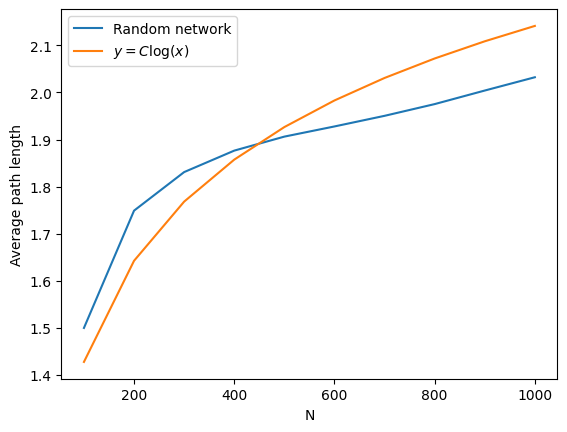

In [25]:
plt.plot(n_nodes, lengths, label='Random network')
plt.xlabel('N')
plt.ylabel('Average path length')
plt.plot(n_nodes, 0.31 * np.log(n_nodes), label='$y=C\log(x)$')
plt.legend()
plt.show()

As we see, the small world phenomenon holds — the average path length increases at most logarithmically with respect to the number of nodes. Theoretically, the diameter $d_\max$ in a random network is

$$d_\max \approx \frac{\ln N}{\ln \langle k \rangle}$$

that corresponds to some real scale-free networks.

### Task 6. Clustering coefficients of random vs real networks (3 points)

Clustering coefficient of a node $C_i$ contains information about relationship between nearest neighbors.  $C_i = 0$ means that there is no links between neighbors and $C_i = 1$ means that there are all possible links between them. Clustering coefficient of an Erdos-Renyi random graph is equal to the probability $p$ and does not dependent of a node and its degree:

$$C_i = \langle C \rangle = \frac{\langle k \rangle}{n} = p $$

Let us check it on generated data.

Write a function `node_degree_clustering` with parameters `n, p` — number of nodes and probability. The function generates Erdos-Renyi random graph and returns a tuple with two np.arrays: degrees and clustering coefficients. Ordering of elements should coincide: the first degree and first clustering coefficient are related to the first node and so on.

*Hint: to calculate clustering coefficients, use `nx.clustering(graph)`*

In [26]:
def node_degree_clustering(n, p):
    G = nx.erdos_renyi_graph(n, p)
    # degrees in the same node order
    degrees = np.array([d for _, d in G.degree()])
    cluster = np.array([nx.clustering(G, v) for v in G.nodes()])
    return degrees, cluster

In [27]:
p = 0.9
n = 100
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.01
n = 3000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()

Let us draw the dependency between node degree and clustering coefficient

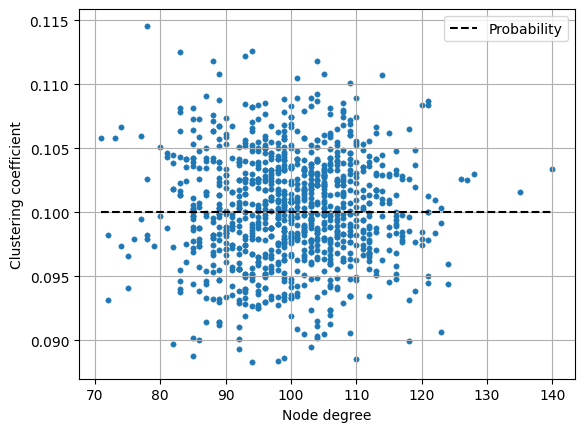

In [28]:
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.plot([degree.min(), degree.max()], [p, p], 'k--', label='Probability')
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.legend()
plt.grid()
plt.show()

Let us look at the dependency of a some real social network.

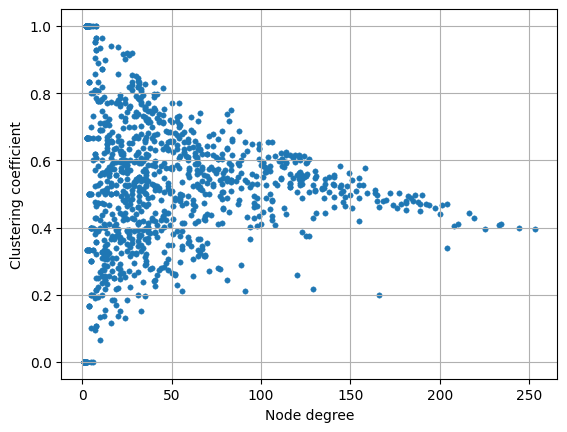

In [29]:
degree = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/real_net_degree.txt'
)
clustering = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/real_net_clustering.txt'
)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.grid()
plt.show()

We can see that the average clustering coefficient slightly decreases in high degrees.

### Task 7. Snobbish networks (2 points)

Consider a network of $N$ red and $N$ blue nodes. The probability that there is a link between nodes of identical color is $p$ and the probability that there is a link between nodes of different color is $q$. A network is snobbish if $p>q$, capturing a tendency to connect to nodes of the same color. For $q = 0$ the network has at least two components, containing nodes with the same color.

Write a function `snobbish_network` that takes the number of red (or blue) nodes `n`, probability of link between nodes of the same color `p` and probability of link between nodes of different color `q`. The function returns a network with $2N$ nodes where every node has an attribute `color` that can be `blue` or `red`.

*Hint: to set node attributes, use `nx.set_node_attributes`*

In [30]:
def snobbish_network(n, p, q):
    G = nx.Graph()

    red = list(range(n))
    blue = list(range(n, 2*n))

    # add all nodes with color attribute
    G.add_nodes_from((i, {"color": "red"}) for i in red)
    G.add_nodes_from((i, {"color": "blue"}) for i in blue)

    # same-color edges with prob p
    for group in (red, blue):
        L = len(group)
        for i in range(L):
            u = group[i]
            for j in range(i+1, L):
                v = group[j]
                if np.random.random() < p:
                    G.add_edge(u, v)

    # cross-color edges with prob q
    for u in red:
        for v in blue:
            if np.random.random() < q:
                G.add_edge(u, v)

    return G

In [31]:
sn_net = snobbish_network(100, 0.1, 0.01)
assert sn_net.number_of_nodes() == 200
assert set(nx.get_node_attributes(sn_net, 'color').values()) == {'blue', 'red'}
assert np.sum(np.array(list(nx.get_node_attributes(sn_net, 'color').values())) == 'red') == 100
assert 0.76 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.88
sn_net = snobbish_network(200, 0.1, 0.05)
assert 0.25 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.4

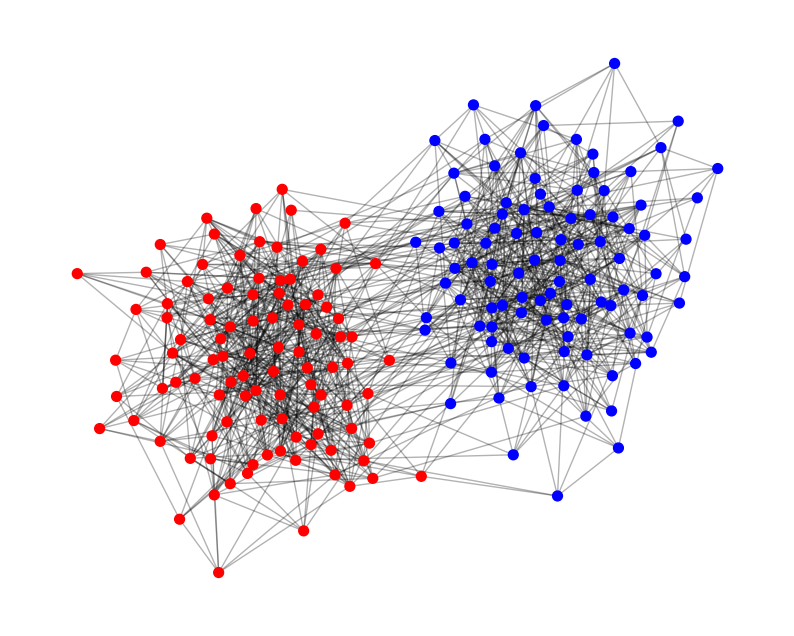

In [32]:
plt.figure(figsize=(10, 8))
sn_net = snobbish_network(100, 0.1, 0.01)
pos = nx.spring_layout(sn_net)
nx.draw_networkx_nodes(
    sn_net,
    pos=pos,
    node_color=nx.get_node_attributes(sn_net, 'color').values(),
    node_size=50)
nx.draw_networkx_edges(sn_net, pos=pos, alpha=0.3)
plt.axis('off')
plt.show()